Final analysis of houshold and family structures, Denmark 1787-1901

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from typing import Tuple, List, Dict, Optional

from pathlib import Path

cwd = Path.cwd()

In [2]:
# cleaning
# We remove the coloumns we dont need for performance reasons
# ll_df = ll_df_full[['pa_id', 'sex', 'marital_status', 'event_year', 'name_cl', 'age', 'event_parish', 'event_county', 'household_id', 'household_position', 'role']]
# ll_df_full = None
# The data is already cleaned and standardized by LL, soo we only need to make a few changes
# some coloumn values are unique within an census, but not between them, soo we need to update these values with the census year
# make the household_id and pa_id unique within the census year
# ll_df['household_id'] = ll_df['household_id'].astype(str) + '_' + ll_df['event_year'].astype(str) + '_' + ll_df['event_county']

# ll_df_cph = ll_df[ll_df['event_county'] == 'københavn']
# ll_df_aarhus = ll_df[ll_df['event_county'] == 'århus']
# ll_df_odense = ll_df[ll_df['event_county'] == 'odense']

In [3]:
# ll_df_cph.to_csv(cwd / 'll_data' / 'll_cph.csv', index=False)
# ll_df_aarhus.to_csv(cwd / 'll_data' / 'll_aarhus.csv', index=False)
# ll_df_odense.to_csv(cwd / 'll_data' / 'll_odense.csv', index=False)

In [4]:
ll_df_cph = pd.read_csv(cwd / 'll_data' / 'll_cph.csv')
ll_df_aarhus = pd.read_csv(cwd / 'll_data' / 'll_aarhus.csv')
ll_df_odense = pd.read_csv(cwd / 'll_data' / 'll_odense.csv')
df_list = [ll_df_cph, ll_df_aarhus, ll_df_odense]
combined_df = pd.concat(df_list)

/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_24986/1301256662.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  ll_df_cph = pd.read_csv(cwd / 'll_data' / 'll_cph.csv')


In [5]:
def analyze_marital_status_distribution(df: pd.DataFrame) -> None:
    """
    Analyzes the distribution of marital status values in the dataset,
    particularly focusing on values that aren't married/unmarried/widowed
    """
    cleaned_df = clean_household_data(df)
    
    # Function to identify solitary households
    def get_solitaries(data):
        households = data.groupby('household_id')
        return pd.concat([hh for _, hh in households if len(hh) == 1])
    
    counties = cleaned_df['event_county'].unique()
    
    for county in counties:
        print(f"\nAnalyzing {county}")
        print("=" * 50)
        
        county_data = cleaned_df[cleaned_df['event_county'] == county]
        years = sorted(county_data['event_year'].unique())
        
        for year in years:
            year_data = county_data[county_data['event_year'] == year]
            solitaries = get_solitaries(year_data)
            
            if len(solitaries) == 0:
                continue
            
            # Analyze marital status distribution
            status_counts = solitaries['marital_status'].value_counts()
            total_count = len(solitaries)
            
            print(f"\nYear: {year}")
            print(f"Total solitary households: {total_count}")
            print("\nMarital status distribution:")
            
            for status, count in status_counts.items():
                percentage = (count / total_count) * 100
                print(f"{status}: {count} ({percentage:.1f}%)")
            
            # Identify entries that don't match our main categories
            main_categories = solitaries['marital_status'].str.match('gift|ugift|enke', case=False, na=False)
            undefined = solitaries[~main_categories]
            
            if len(undefined) > 0:
                print("\nDetailed look at undefined statuses:")
                print("--------------------------------")
                for idx, row in undefined.iterrows():
                    print(f"Status: {row['marital_status']}, Age: {row['age']}, Sex: {row['sex']}")
            
            print("\n" + "-"*30)

# Run the analysis
analyze_marital_status_distribution(combined_df)

NameError: name 'clean_household_data' is not defined

# We try to estimate the fertility rate of married women in the census

In [10]:
def analyze_fertility(df_list, county_names):
    """
    Analyze fertility patterns of married women using both strict and broad definitions
    """
    # Combine all dataframes
    for df, county in zip(df_list, county_names):
        if 'event_county' not in df.columns:
            df['event_county'] = county
    combined_df = pd.concat(df_list, ignore_index=True)
    
    # Initialize results storage
    results = {
        'county_level': {},
        'parish_level': {},
        'aggregate': {}
    }
    
    # Process each county
    for county in county_names:
        county_data = combined_df[combined_df['event_county'] == county]
        results['county_level'][county] = {}
        results['parish_level'][county] = {}
        
        # Process each year
        for year in sorted(county_data['event_year'].unique()):
            year_data = county_data[county_data['event_year'] == year]
            
            # Get all households with married women
            married_women = year_data[
                (year_data['sex'] == 'f') & 
                (year_data['marital_status'] == 'gift')
            ]
            
            # Initialize parish-level storage for this year
            results['parish_level'][county][year] = {}
            
            # Calculate fertility for each parish
            parish_results = []
            for parish in year_data['event_parish'].unique():
                parish_data = year_data[year_data['event_parish'] == parish]
                parish_married_women = married_women[married_women['event_parish'] == parish]
                
                if len(parish_married_women) > 0:
                    # Calculate both fertility measures for parish
                    strict_children = 0
                    broad_children = 0
                    
                    for _, woman in parish_married_women.iterrows():
                        # Get household members
                        household = parish_data[
                            parish_data['household_id'] == woman['household_id']
                        ]
                        
                        # Strict count (role marked as child)
                        strict_children += len(household[
                            household['household_position'].str.contains('børn|barn|datter|søn',
                                                         case=False, 
                                                         na=False)
                        ])
                        
                        # Broad count (anyone under 15)
                        broad_children += len(household[household['age'] < 15])
                    
                    parish_results.append({
                        'parish': parish,
                        'married_women': len(parish_married_women),
                        'strict_children': strict_children,
                        'broad_children': broad_children,
                        'strict_fertility': strict_children / len(parish_married_women),
                        'broad_fertility': broad_children / len(parish_married_women)
                    })
            
            # Store parish-level results
            if parish_results:
                parish_df = pd.DataFrame(parish_results)
                results['parish_level'][county][year] = parish_df
                
                # Calculate county-level aggregates
                results['county_level'][county][year] = {
                    'married_women': parish_df['married_women'].sum(),
                    'strict_fertility': (parish_df['strict_children'].sum() / 
                                       parish_df['married_women'].sum()),
                    'broad_fertility': (parish_df['broad_children'].sum() / 
                                      parish_df['married_women'].sum())
                }
    
    # Calculate aggregate results for each year
    years = sorted(set(year for county_data in results['county_level'].values() 
                      for year in county_data.keys()))
    
    for year in years:
        total_women = 0
        total_strict_children = 0
        total_broad_children = 0
        
        for county in county_names:
            if year in results['county_level'][county]:
                county_data = results['county_level'][county][year]
                total_women += county_data['married_women']
                total_strict_children += (county_data['strict_fertility'] * 
                                        county_data['married_women'])
                total_broad_children += (county_data['broad_fertility'] * 
                                       county_data['married_women'])
        
        if total_women > 0:
            results['aggregate'][year] = {
                'married_women': total_women,
                'strict_fertility': total_strict_children / total_women,
                'broad_fertility': total_broad_children / total_women
            }
    
    return results

def print_fertility_summary(results):
    """
    Print formatted fertility analysis results
    """
    print("=== FERTILITY ANALYSIS SUMMARY ===\n")
    
    # Print aggregate results
    print("AGGREGATE FERTILITY RATES")
    print("-" * 70)
    print("Year | Married Women | Strict Fertility | Broad Fertility")
    print("-" * 70)
    
    for year in sorted(results['aggregate'].keys()):
        data = results['aggregate'][year]
        print(f"{year} | {data['married_women']:^13d} | "
              f"{data['strict_fertility']:^15.2f} | "
              f"{data['broad_fertility']:^14.2f}")
    
    # Print county-level results
    print("\nCOUNTY-LEVEL FERTILITY RATES")
    for county in results['county_level'].keys():
        print(f"\n{county}")
        print("-" * 70)
        print("Year | Married Women | Strict Fertility | Broad Fertility")
        print("-" * 70)
        
        for year in sorted(results['county_level'][county].keys()):
            data = results['county_level'][county][year]
            print(f"{year} | {data['married_women']:^13d} | "
                  f"{data['strict_fertility']:^15.2f} | "
                  f"{data['broad_fertility']:^14.2f}")
    
    # Print parish-level results
    print("\nPARISH-LEVEL FERTILITY RATES")
    for county in results['parish_level'].keys():
        print(f"\n{county}")
        for year in sorted(results['parish_level'][county].keys()):
            print(f"\nYear: {year}")
            print("-" * 85)
            print("Parish | Married Women | Strict Fertility | Broad Fertility")
            print("-" * 85)
            
            parish_df = results['parish_level'][county][year]
            for _, row in parish_df.iterrows():
                print(f"{row['parish'][:20]:20s} | {row['married_women']:^13d} | "
                      f"{row['strict_fertility']:^15.2f} | "
                      f"{row['broad_fertility']:^14.2f}")

def create_fertility_visualization(results):
    """
    Create visualization comparing fertility rates across counties over time
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Prepare data for plotting
    counties = list(results['county_level'].keys())
    years = sorted(set(year for county_data in results['county_level'].values() 
                      for year in county_data.keys()))
    
    # Plot strict fertility rates
    for county in counties:
        county_years = sorted(results['county_level'][county].keys())
        strict_rates = [results['county_level'][county][year]['strict_fertility'] 
                       for year in county_years]
        ax1.plot(county_years, strict_rates, marker='o', label=county)
    
    ax1.set_title('Strict Fertility Rates Over Time')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Children per Married Woman')
    ax1.legend()
    ax1.grid(True)
    
    # Plot broad fertility rates
    for county in counties:
        county_years = sorted(results['county_level'][county].keys())
        broad_rates = [results['county_level'][county][year]['broad_fertility'] 
                      for year in county_years]
        ax2.plot(county_years, broad_rates, marker='o', label=county)
    
    ax2.set_title('Broad Fertility Rates Over Time')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Children per Married Woman')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    return fig

=== FERTILITY ANALYSIS SUMMARY ===

AGGREGATE FERTILITY RATES
----------------------------------------------------------------------
Year | Married Women | Strict Fertility | Broad Fertility
----------------------------------------------------------------------

COUNTY-LEVEL FERTILITY RATES

København
----------------------------------------------------------------------
Year | Married Women | Strict Fertility | Broad Fertility
----------------------------------------------------------------------

Århus
----------------------------------------------------------------------
Year | Married Women | Strict Fertility | Broad Fertility
----------------------------------------------------------------------

Odense
----------------------------------------------------------------------
Year | Married Women | Strict Fertility | Broad Fertility
----------------------------------------------------------------------

PARISH-LEVEL FERTILITY RATES

København

Århus

Odense


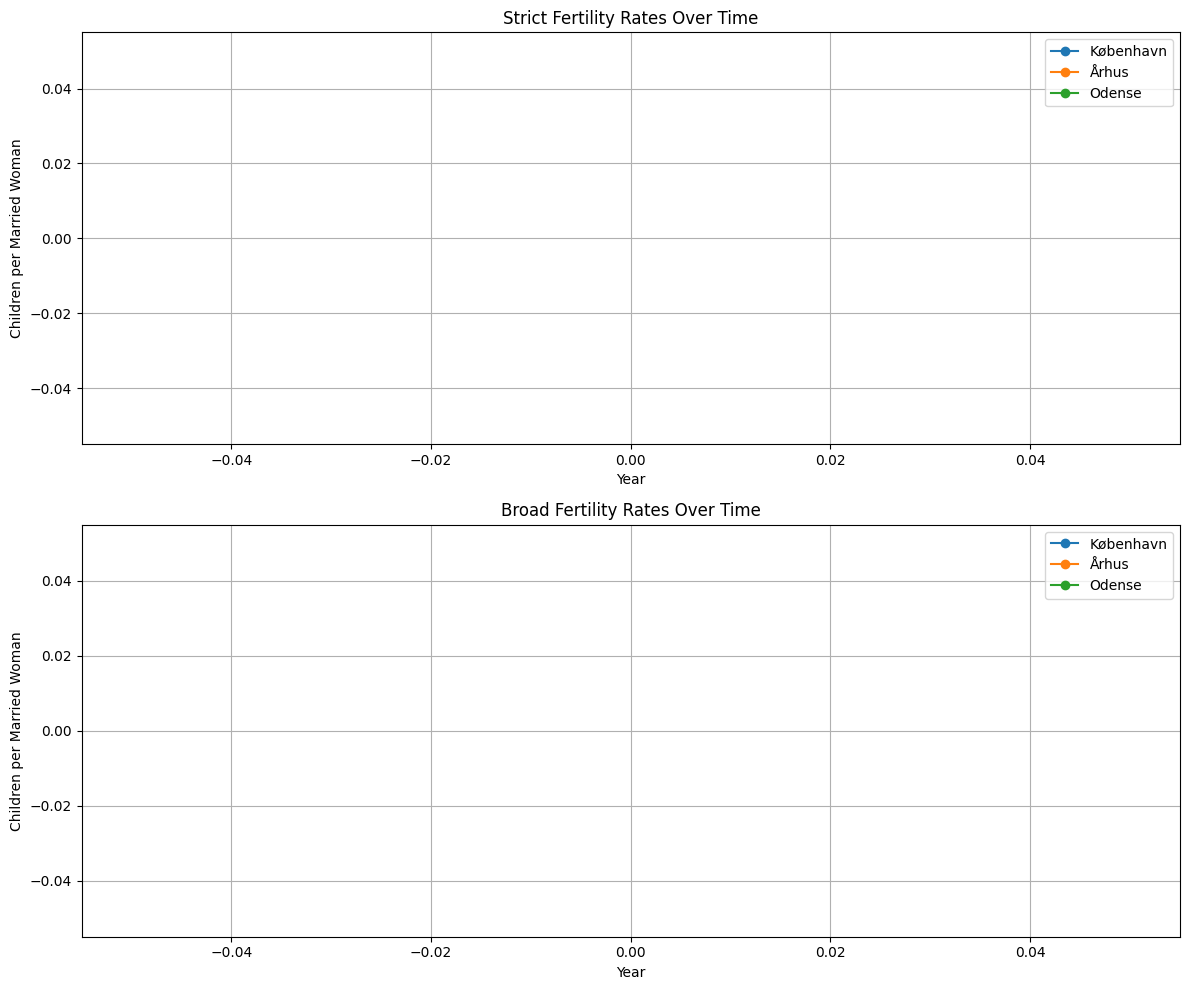

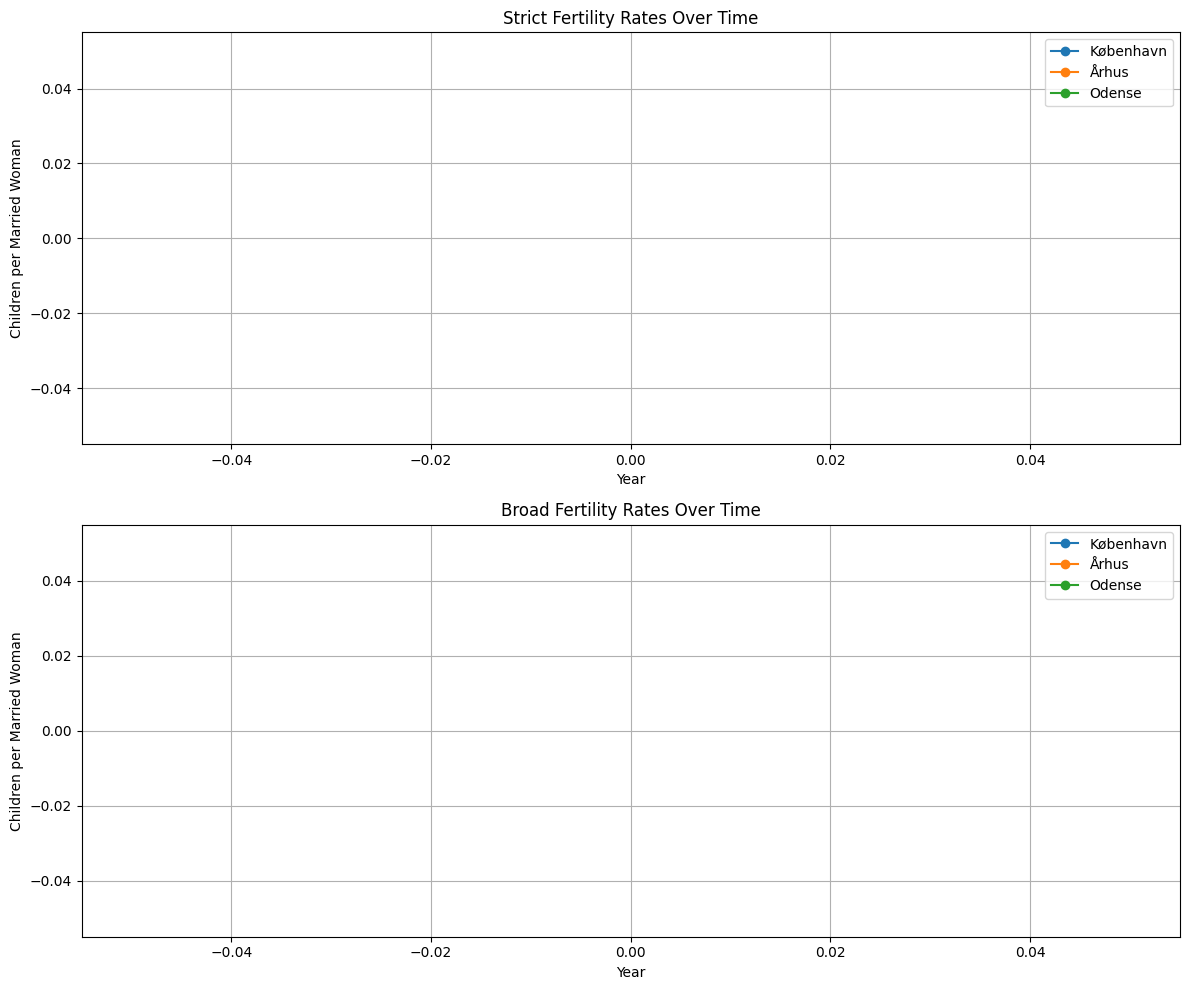

In [12]:
county_names = ['København', 'Århus', 'Odense']
results = analyze_fertility(df_list, county_names)
print_fertility_summary(results)
create_fertility_visualization(results)

# We expand the fertility analysis to use more complicated methods

In [33]:
from typing import List, Dict, Tuple, Optional, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class FertilityResults:
    county: str
    year: int
    cwr: float
    ocm: float
    asfr: Dict[str, float]

def calculate_child_woman_ratio(data: pd.DataFrame) -> float:
    """Optimized CWR calculation"""
    young_children = (data['age'] <= 4).sum()
    women_childbearing = ((data['sex'] == 'f') & 
                         (data['age'] >= 15) & 
                         (data['age'] <= 49)).sum()
    
    return (young_children / women_childbearing * 1000) if women_childbearing > 0 else 0

def calculate_own_children_fertility(data: pd.DataFrame) -> float:
    """Optimized OCM calculation using groupby operations"""
    # Pre-filter for efficiency
    mothers = data[(data['sex'] == 'f') & (data['marital_status'] == 'gift')]
    
    if len(mothers) == 0:
        return 0
    
    # Create a household children count series
    children_mask = (data['household_position'].str.contains('børn|barn|datter|søn|son|born', case=False, na=False))
    household_children = data[children_mask].groupby('household_id').size()
    
    # Match mothers with their household's children count
    mothers_children = mothers['household_id'].map(household_children.get).fillna(0)
    
    return mothers_children.mean()

def calculate_age_specific_fertility(data: pd.DataFrame) -> Dict[str, float]:
    """Optimized ASFR calculation using groupby operations"""
    age_groups: List[Tuple[int, int]] = [(20,24), (25,29), (30,34), (35,39), (40,44)]
    rates: Dict[str, float] = {}
    
    # Pre-calculate household children counts
    children_mask = ((data['age'] < 15) & 
                    (data['household_position'].str.contains('børn|barn|datter|søn|son|born', case=False, na=False)))
    household_children = data[children_mask].groupby('household_id').size()
    
    for min_age, max_age in age_groups:
        # Get women in this age group
        women = data[(data['sex'] == 'f') & 
                    (data['marital_status'] == 'gift') &
                    (data['age'] >= min_age) & 
                    (data['age'] <= max_age)]
        
        if len(women) == 0:
            rates[f"{min_age}-{max_age}"] = 0
            continue
            
        # Match women with their household's children count
        women_children = women['household_id'].map(household_children.get).fillna(0)
        rates[f"{min_age}-{max_age}"] = women_children.mean()
    
    return rates

def analyze_fertility_methods(df_list: List[pd.DataFrame], 
                            county_names: List[str]) -> Dict[str, List[FertilityResults]]:
    """Optimized main analysis function"""
    # Combine dataframes
    for df, county in zip(df_list, county_names):
        if 'event_county' not in df.columns:
            df['event_county'] = county
    combined_df = pd.concat(df_list, ignore_index=True)
    
    results: Dict[str, List[FertilityResults]] = {county: [] for county in county_names}
    
    # Process each county and year
    for county in county_names:
        county_data = combined_df[combined_df['event_county'] == county]
        
        for year in sorted(county_data['event_year'].unique()):
            year_data = county_data[county_data['event_year'] == year]
            
            results[county].append(FertilityResults(
                county=county,
                year=year,
                cwr=calculate_child_woman_ratio(year_data),
                ocm=calculate_own_children_fertility(year_data),
                asfr=calculate_age_specific_fertility(year_data)
            ))
    
    return results

def create_fertility_visualizations(results: Dict[str, List[FertilityResults]]) -> Dict[str, plt.Figure]:
    """
    Create visualizations for all fertility measures, with ASFR using facets
    
    Args:
        results: Dictionary of fertility results by county
    
    Returns:
        Dictionary of matplotlib figures
    """
    figures: Dict[str, plt.Figure] = {}
    
    # Child-Woman Ratio Plot remains the same
    fig_cwr, ax_cwr = plt.subplots(figsize=(12, 6))
    for county, county_results in results.items():
        years = [r.year for r in county_results]
        cwrs = [r.cwr for r in county_results]
        ax_cwr.plot(years, cwrs, marker='o', label=county)
    
    ax_cwr.set_title('Child-Woman Ratio Over Time\n(Children 0-4 per 1000 Women 15-49)')
    ax_cwr.set_xlabel('Year')
    ax_cwr.set_ylabel('Child-Woman Ratio')
    ax_cwr.legend()
    ax_cwr.grid(True)
    figures['cwr'] = fig_cwr
    
    # Own-Children Method Plot remains the same
    fig_ocm, ax_ocm = plt.subplots(figsize=(12, 6))
    for county, county_results in results.items():
        years = [r.year for r in county_results]
        ocms = [r.ocm for r in county_results]
        ax_ocm.plot(years, ocms, marker='o', label=county)
    
    ax_ocm.set_title('Own-Children Method Fertility Estimates Over Time')
    ax_ocm.set_xlabel('Year')
    ax_ocm.set_ylabel('Children per Married Woman')
    ax_ocm.legend()
    ax_ocm.grid(True)
    figures['ocm'] = fig_ocm
    
    # Create new faceted ASFR plot
    # First, prepare the data in a format suitable for faceting
    age_groups = list(next(iter(results.values()))[0].asfr.keys())
    plot_data = []
    
    for county, county_results in results.items():
        for result in county_results:
            for age_group, rate in result.asfr.items():
                plot_data.append({
                    'County': county,
                    'Year': result.year,
                    'Age Group': age_group,
                    'Fertility Rate': rate
                })
    
    df_plot = pd.DataFrame(plot_data)
    
    # Create faceted plot
    n_age_groups = len(age_groups)
    fig_asfr, axes = plt.subplots(n_age_groups, 1, figsize=(12, 3*n_age_groups))
    
    # Ensure axes is always a list, even with one subplot
    if n_age_groups == 1:
        axes = [axes]
    
    # Plot each age group in its own facet
    for ax, age_group in zip(axes, sorted(age_groups)):
        age_group_data = df_plot[df_plot['Age Group'] == age_group]
        
        for county in results.keys():
            county_data = age_group_data[age_group_data['County'] == county]
            ax.plot(county_data['Year'], county_data['Fertility Rate'], 
                   marker='o', label=county)
        
        ax.set_title(f'Age Group: {age_group}')
        ax.set_ylabel('Children per Married Woman')
        ax.grid(True)
        ax.legend()
    
    # Add common xlabel to the bottom
    axes[-1].set_xlabel('Year')
    
    # Add overall title
    fig_asfr.suptitle('Age-Specific Fertility Rates Over Time by Age Group', 
                      y=1.02, fontsize=12)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    figures['asfr'] = fig_asfr
    
    return figures

def print_fertility_summary_county(results: Dict[str, List[FertilityResults]]) -> None:
    """
    Print summary of fertility analysis results

    Args:
        results: Dictionary of fertility results by county
    """
    print("=== FERTILITY ANALYSIS SUMMARY ===\n")

    for county, county_results in results.items():
        print(f"\n{county.upper()}")
        print("-" * 80)
        print("Year | Child-Woman Ratio | Own-Children Method | ASFR (20-24) | ASFR (30-34) | ASFR (40-44)")
        print("-" * 80)
        
        for result in sorted(county_results, key=lambda x: x.year):
            print(f"{result.year} | "
                    f"{result.cwr:^16.1f} | "
                    f"{result.ocm:^17.2f} | "
                    f"{result.asfr['20-24']:^11.2f} | "
                    f"{result.asfr['30-34']:^11.2f} | "
                    f"{result.asfr['40-44']:^11.2f}")


In [ ]:
# Run the optimized analysis
fertility_results = analyze_fertility_methods(df_list, county_names)

# Print results and create visualizations as before
print_fertility_summary_county(fertility_results)
figures = create_fertility_visualizations(fertility_results)

for method, fig in figures.items():
    plt.figure(fig.number)
    plt.show()

# We estimate the net migration to København

In [35]:
from typing import Dict, List, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def estimate_migration(data: pd.DataFrame, 
                      fertility_results: List[FertilityResults],
                      infant_mortality_rate: float = 0.20,
                      child_mortality_rate: float = 0.25) -> Dict[int, Dict[str, float]]:
    """
    Estimate migration for København using demographic components
    
    Args:
        data: DataFrame containing København census data
        fertility_results: Fertility analysis results
        infant_mortality_rate: Estimated proportion of deaths in first year
        child_mortality_rate: Estimated proportion of deaths ages 1-5
    
    Returns:
        Dictionary of estimates by year
    """
    estimates = {}
    years = sorted(data['event_year'].unique())
    
    # Calculate for each year interval
    for i in range(len(years)-1):
        year1 = years[i]
        year2 = years[i+1]
        interval = year2 - year1
        
        # Get population counts
        pop1 = len(data[data['event_year'] == year1])
        pop2 = len(data[data['event_year'] == year2])
        total_change = pop2 - pop1
        
        # Estimate births in the interval
        year1_data = data[data['event_year'] == year1]
        married_women = len(year1_data[
            (year1_data['sex'] == 'f') & 
            (year1_data['marital_status'] == 'gift')
        ])
        
        # Get fertility rate for this year
        fertility_rate = next(r.ocm for r in fertility_results 
                            if r.year == year1)
        
        # Estimate annual births and adjust for interval length
        estimated_annual_births = married_women * fertility_rate
        total_births = estimated_annual_births * interval
        
        # Estimate survivors from births
        survivors_from_births = total_births * (1 - infant_mortality_rate) * (1 - child_mortality_rate)
        
        # Estimate deaths in existing population (rough estimate)
        # Assume 2% annual mortality for existing population
        annual_death_rate = 0.02
        total_deaths = pop1 * (1 - (1 - annual_death_rate)**interval)
        
        # Calculate implied net migration
        natural_increase = survivors_from_births - total_deaths
        net_migration = total_change - natural_increase
        
        estimates[year1] = {
            'interval_end': year2,
            'total_change': total_change,
            'estimated_births': total_births,
            'surviving_births': survivors_from_births,
            'estimated_deaths': total_deaths,
            'natural_increase': natural_increase,
            'net_migration': net_migration,
            'annual_net_migration': net_migration / interval
        }
    
    return estimates

def plot_migration_components(estimates: Dict[int, Dict[str, float]]) -> plt.Figure:
    """
    Create visualization of population change components
    """
    years = sorted(estimates.keys())
    
    # Prepare data for plotting
    components = {
        'Natural Increase': [estimates[year]['natural_increase'] for year in years],
        'Net Migration': [estimates[year]['net_migration'] for year in years]
    }
    
    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    bottom = np.zeros(len(years))
    
    for label, data in components.items():
        ax.bar(years, data, bottom=bottom, label=label)
        bottom += np.array(data)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_title('Components of Population Change in København')
    ax.set_xlabel('Starting Year of Interval')
    ax.set_ylabel('Number of People')
    ax.legend()
    
    # Add total change line
    total_changes = [estimates[year]['total_change'] for year in years]
    ax2 = ax.twinx()
    ax2.plot(years, total_changes, 'r--', label='Total Change')
    ax2.set_ylabel('Total Population Change')
    
    plt.tight_layout()
    return fig

def print_migration_summary(estimates: Dict[int, Dict[str, float]]) -> None:
    """
    Print detailed summary of migration estimates
    """
    print("=== KØBENHAVN MIGRATION ESTIMATES ===\n")
    print("Time Period | Total Change | Natural Increase | Net Migration | Annual Migration")
    print("-" * 75)
    
    for year, data in sorted(estimates.items()):
        print(f"{year}-{data['interval_end']} | "
              f"{data['total_change']:^12.0f} | "
              f"{data['natural_increase']:^15.0f} | "
              f"{data['net_migration']:^12.0f} | "
              f"{data['annual_net_migration']:^15.0f}")
    
    print("\nNote: These estimates are based on several assumptions:")
    print("1. Infant mortality rate: 20%")
    print("2. Child mortality rate: 25%")
    print("3. General population mortality rate: 2% annually")
    print("4. All births are to married women")
    print("5. Migration is uniform within each interval")

In [ ]:
# Get København data
kbh_data = next(df for df, county in zip(df_list, county_names) 
                if county == 'københavn')

# Get København fertility results
kbh_fertility = next(results for county, results in fertility_results.items() 
                    if county == 'københavn')

# Calculate migration estimates
migration_estimates = estimate_migration(kbh_data, kbh_fertility)

# Print summary
print_migration_summary(migration_estimates)

# Create and display visualization
fig = plot_migration_components(migration_estimates)
plt.show()

# We plot average family size for all counties over time

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

def identify_servants(position):
    """
    Identifies if a household position indicates a servant role.
    
    Parameters:
    -----------
    position : str
        The household position string to check
    
    Returns:
    --------
    bool
        True if the position indicates a servant role, False otherwise
    """
    if pd.isna(position):
        return False
        
    servant_terms = [
        'tjeneste', 'tjener', 'tjenestepige', 'tjenestekarl',
        'husholderske', 'kokkepige', 'stuepige', 'barnepige'
    ]
    
    return any(term.lower() in str(position).lower() for term in servant_terms)

def filter_large_households(df, max_size=20):
    """
    Filters out households larger than the specified size.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing census data
    max_size : int
        Maximum allowed household size (default: 20)
    
    Returns:
    --------
    pandas.DataFrame
        Filtered DataFrame excluding large households
    """
    # Count total members in each household
    household_sizes = df.groupby('household_id').size()
    
    # Get list of households to keep
    valid_households = household_sizes[household_sizes <= max_size].index
    
    # Filter the dataframe
    return df[df['household_id'].isin(valid_households)]

def calculate_household_sizes_excluding_servants(copenhagen_df, aarhus_df, odense_df, max_household_size=20):
    """
    Calculates average household sizes both including and excluding servants,
    filtering out households larger than max_household_size.
    
    Parameters:
    -----------
    copenhagen_df, aarhus_df, odense_df : pandas.DataFrame
        DataFrames containing census data
    max_household_size : int
        Maximum allowed household size (default: 20)
    
    Returns:
    --------
    pandas.DataFrame
        Statistics about household sizes by county and year
    """
    results = []
    
    for df, county in [(copenhagen_df, 'København'), 
                       (aarhus_df, 'Århus'), 
                       (odense_df, 'Odense')]:
        
        # Add servant indicator
        df['is_servant'] = df['household_position'].apply(identify_servants)
        
        for year in sorted(df['event_year'].unique()):
            # Filter data for this year
            year_data = df[df['event_year'] == year]
            
            # Filter out large households
            year_data = filter_large_households(year_data, max_household_size)
            
            # Calculate sizes including servants
            total_household_sizes = year_data.groupby('household_id').size()
            avg_total_size = total_household_sizes.mean()
            
            # Calculate sizes excluding servants
            non_servant_data = year_data[~year_data['is_servant']]
            core_household_sizes = non_servant_data.groupby('household_id').size()
            avg_core_size = core_household_sizes.mean()
            
            # Calculate servant statistics
            total_servants = year_data['is_servant'].sum()
            households_with_servants = year_data[year_data['is_servant']]['household_id'].nunique()
            
            # Count excluded households
            original_households = df[df['event_year'] == year]['household_id'].nunique()
            filtered_households = len(total_household_sizes)
            excluded_households = original_households - filtered_households
            
            results.append({
                'County': county,
                'Year': year,
                'Average_Total_Size': round(avg_total_size, 2),
                'Average_Core_Size': round(avg_core_size, 2),
                'Servant_Difference': round(avg_total_size - avg_core_size, 2),
                'Total_Households': filtered_households,
                'Excluded_Households': excluded_households,
                'Households_With_Servants': households_with_servants,
                'Total_Servants': total_servants
            })
    
    return pd.DataFrame(results).sort_values(['County', 'Year'])

def visualize_household_sizes(results_df: pd.DataFrame):
    """
    Creates visualizations comparing household sizes with and without servants.
    """
    plt.style.use('seaborn-v0_8-notebook')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Define colors for each county
    county_colors = {
        'København': 'blue',
        'Århus': 'orange',
        'Odense': 'green'
    }
    
    # Plot 1: Total vs Core Household Sizes
    for county in county_colors.keys():
        county_data = results_df[results_df['County'] == county]
        
        # Plot total household size
        ax1.plot(county_data['Year'], 
                county_data['Average_Total_Size'],
                color=county_colors[county],
                marker='o',
                label=f'{county} (with servants)',
                linewidth=2,
                linestyle='-')
        
        # Plot core household size
        ax1.plot(county_data['Year'], 
                county_data['Average_Core_Size'],
                color=county_colors[county],
                marker='s',
                label=f'{county} (without servants)',
                linewidth=2,
                linestyle='--')
    
    ax1.set_title('Average Household Sizes: Total vs Core Family\n(Excluding Households > 20 People)',
                 fontsize=14, pad=20)
    ax1.set_xlabel('Census Year', fontsize=12)
    ax1.set_ylabel('Average Household Size', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(title='County and Type', title_fontsize=12)
    
    # Plot 2: Average Number of Servants per Household with Servants
    for county in county_colors.keys():
        county_data = results_df[results_df['County'] == county]
        servants_per_household = county_data['Total_Servants'] / county_data['Households_With_Servants']
        
        ax2.plot(county_data['Year'], 
                servants_per_household,
                color=county_colors[county],
                marker='o',
                label=county,
                linewidth=2)
    
    ax2.set_title('Average Number of Servants per Household (Among Houses with Servants)\n(Excluding Households > 20 People)',
                 fontsize=14, pad=20)
    ax2.set_xlabel('Census Year', fontsize=12)
    ax2.set_ylabel('Average Number of Servants', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(title='County', title_fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics about excluded households
    print("\nHouseholds Excluded from Analysis (Size > 20):")
    print("============================================")
    excluded_stats = results_df.groupby('County').agg({
        'Excluded_Households': ['sum', 'mean'],
        'Total_Households': 'sum'
    }).round(2)
    
    excluded_stats['Excluded_Percentage'] = (
        excluded_stats['Excluded_Households']['sum'] / 
        (excluded_stats['Excluded_Households']['sum'] + excluded_stats['Total_Households']) * 100
    ).round(2)
    
    print(tabulate(excluded_stats, headers='keys', tablefmt='pretty'))
    
    # Print detailed statistics
    print("\nHousehold Size Statistics by County and Year:")
    print("=========================================")
    
    print(tabulate(results_df, headers='keys', tablefmt='pretty', 
                  floatfmt=".2f", showindex=False))

def analyze_households_and_servants(copenhagen_df, aarhus_df, odense_df, max_household_size=20):
    """
    Main function to run the complete household size analysis
    """
    results = calculate_household_sizes_excluding_servants(
        copenhagen_df, aarhus_df, odense_df, max_household_size
    )
    visualize_household_sizes(results)
    return results
results = analyze_households_and_servants(ll_df_cph, ll_df_aarhus, ll_df_odense)


# We try to see how many people lived in towns over 10.000 people

In [1]:
import pandas as pd
from pathlib import Path
# Load in data
cwd = Path.cwd()
ll_data = cwd / 'll_data' / 'combined_ll_census_1787-1901.csv'
ll_df_full = pd.read_csv(ll_data)

# group by town and year
grouped = ll_df_full.groupby(['event_county', 'event_year']).agg({'name': 'count'}).reset_index()

grouped = grouped.rename(columns={'name': 'count'})
# Figure out how many towns are above 10000 people
large_towns = grouped[grouped['count'] > 10000]

/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_1950/545706579.py:6: DtypeWarning: Columns (6,13,21,22,23,24,25,26,27,28,30,32,40) have mixed types. Specify dtype option on import or set low_memory=False.
  ll_df_full = pd.read_csv(ll_data)


ValueError: x and y must have same first dimension, but have shapes (7,) and (9,)

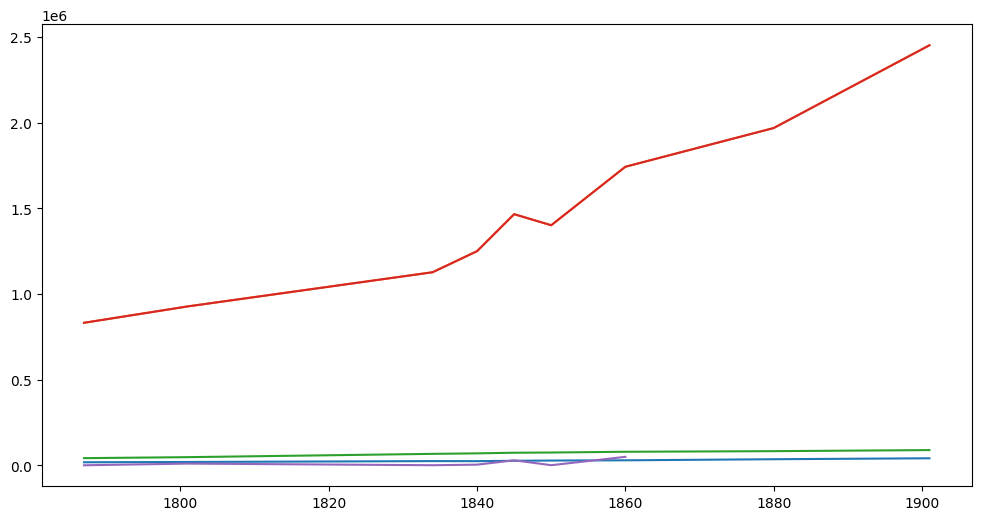

In [7]:
import matplotlib.pyplot as plt


# plot
plt.figure(figsize=(12, 6))
for county in grouped['event_county'].unique():
    county_data = grouped[grouped['event_county'] == county]
    amount_of_people_in_small_towns = county_data.groupby('event_year')['count'].sum()
    plt.plot(county_data['event_year'], amount_of_people_in_small_towns, label=county + 'people in towns')
    amont_of_people_in_large_towns = large_towns.groupby('event_year')['count'].sum()
    plt.plot(county_data['event_year'], amont_of_people_in_large_towns, label=county + 'people in large towns')